# Introduction
[Jinxuan Lu - Assignment 1]

Dataset source: https://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts

This dataset includes Reddit posts collected from Liberal and Conservative leaning subreddits based on their self-descriptions, such as "Socialism" as a liberal leaning subreddit, and "Libertarian" as a more conservative leaning subreddit. 

(The more specific manual political classification method can be refered to this article as well: https://journals.sagepub.com/doi/pdf/10.1177/20539517221076486 since it uses similar way to study Reddit posts on COVID-19 related opinions.)

I chose this dataset becasue I am interested in the political environment on Reddit, and people usually focus on Twitter and other platforms more, and Reddit is less studied. Moreover, this dataset includes pre-classified political leans, which I think would be intereting to cross compare political leans with other variables.

### Table of Contents

1. Data Cleaning & Exploratory Data Analysis (EDA)
2. Data Proprocessing
   - Sampling
   - Text Normalization
   - Text Exploration
   - N-gram Exploration
3. Sentiment Analysis
   - HuggingFace Transformers
   - NLTK VADER
   - Comparison
4. Visualization of Sentiment Analysis Results
5. Conclusion
6. Reference

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import spacy
import re, string
from spacy.lang.en.stop_words import STOP_WORDS
# conda install -c huggingface transformers

%matplotlib inline

# Import Dataset & EDA

In [2]:
# import dataset
df = pd.read_csv('file_name.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854 entries, 0 to 12853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            12854 non-null  object 
 1   Political Lean   12854 non-null  object 
 2   Score            12854 non-null  int64  
 3   Id               12854 non-null  object 
 4   Subreddit        12854 non-null  object 
 5   URL              12854 non-null  object 
 6   Num of Comments  12854 non-null  int64  
 7   Text             2428 non-null   object 
 8   Date Created     12854 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 903.9+ KB


,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,1.646270e+09
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,1.646270e+09
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,1.646268e+09


We can see that there are 12,854 rows and 9 columns. Let's first understand what each column entails.

- Title - title of post
- Political Lean - political ideological leaning of the post: liberal & conservative
- Score - score of post based on impact (equals to number of upvotes minus downvotes)
- Id - unique id for posts
- URL - url of post thread
- Num of Comments - number of comments to this post
- Text - text of the post or comment
- Date Created - timestamp of creation

In [3]:
# drop columns that are not that useful in this project
df.drop(columns=['Id', 'URL'], inplace=True)

# change names into lowercase
df.columns = ['title', 'political_lean', 'score', 'subreddit', 'comments_num', 'text', 'date_created']
df.head()

,title,political_lean,score,subreddit,comments_num,text,date_created
0,"No matter who someone is, how they look like, ...",Liberal,1,socialism,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,democrats,1,NaN,1.646271e+09
2,State of the union,Liberal,1,DemocraticSocialism,1,Who watched the state of the union last night ...,1.646270e+09
3,We Should Just Give Poor People Money,Liberal,7,SocialDemocracy,3,NaN,1.646270e+09
4,Do it for the Dew,Liberal,6,democrats,1,NaN,1.646268e+09


In [4]:
# checking missing data
def missing_data(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing_data(df)
# df.dropna(subset=['text'],inplace=True) 

,title,political_lean,score,subreddit,comments_num,text,date_created
Total,0,0,0,0,0,10426,0
Percent,0.0,0.0,0.0,0.0,0.0,81.110938,0.0
Types,object,object,int64,object,int64,object,float64


There are approximately 80% of the data missing under text, which is expected as some users might only share the post with title and url (already removed). 

However, it would be not that necessary to drop NA since I decided to focus on "title" rather than "text", because title is more important on Reddit when users post their content to attract viewers. 

Liberal         8319
Conservative    4535
Name: political_lean, dtype: int64


<AxesSubplot:xlabel='political_lean', ylabel='count'>

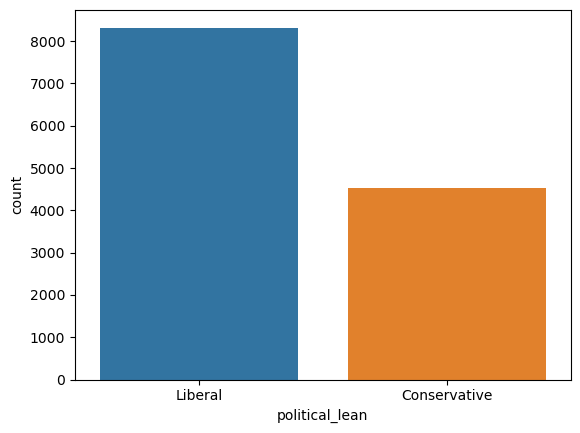

In [5]:
# looking at political lean distribution
print(df['political_lean'].value_counts())

sns.countplot(data=df,x='political_lean')

In [6]:
# dealing with date
from datetime import datetime
Date = [ ]
for date in df['date_created']:
    Date.append(datetime.fromtimestamp(date))    # convert timestamp to date

df['date'] = Date
df.drop(columns=['date_created'], inplace=True)

df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S') # convert date from object to datetime for subsequent analysis and plotting.
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854 entries, 0 to 12853
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           12854 non-null  object        
 1   political_lean  12854 non-null  object        
 2   score           12854 non-null  int64         
 3   subreddit       12854 non-null  object        
 4   comments_num    12854 non-null  int64         
 5   text            2428 non-null   object        
 6   date            12854 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 703.1+ KB


,title,political_lean,score,subreddit,comments_num,text,date
0,"No matter who someone is, how they look like, ...",Liberal,1,socialism,0,NaN,2022-03-03 02:42:57
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,democrats,1,NaN,2022-03-03 02:31:48
2,State of the union,Liberal,1,DemocraticSocialism,1,Who watched the state of the union last night ...,2022-03-03 02:21:28
3,We Should Just Give Poor People Money,Liberal,7,SocialDemocracy,3,NaN,2022-03-03 02:05:08
4,Do it for the Dew,Liberal,6,democrats,1,NaN,2022-03-03 01:43:03


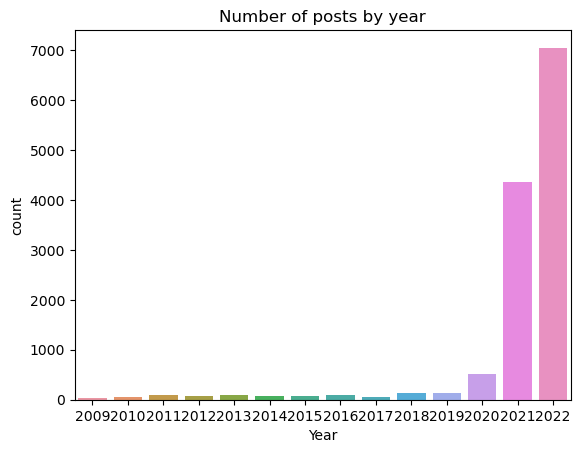

In [7]:
# Extract year and month of the data
df['Year'] = pd.DatetimeIndex(df['date']).year
df['Month'] = pd.DatetimeIndex(df['date']).month

# Create a count plot
sns.countplot(x='Year', data=df)
plt.title('Number of posts by year')
plt.show()

<AxesSubplot:xlabel='count', ylabel='subreddit'>

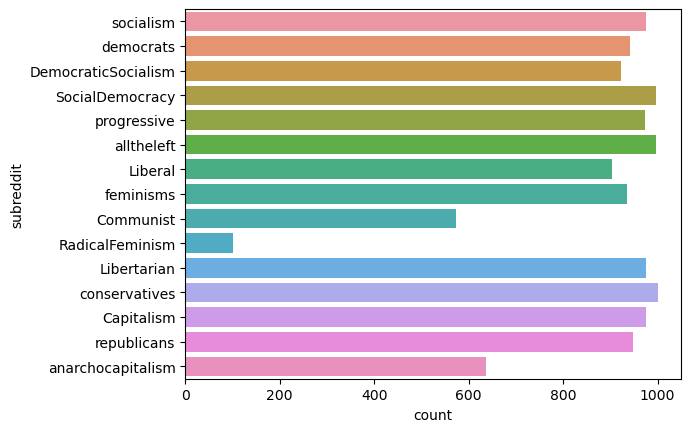

In [8]:
sns.countplot(data=df,y='subreddit')

From the plots, we know that the number of posts was in a minimum level until a uptrending from 2020, and then a surge from 2021. The reason could be some of the subreddits had not been created before 2020, or some of them had been banned by Reddit, such as "RadicalFeminism"

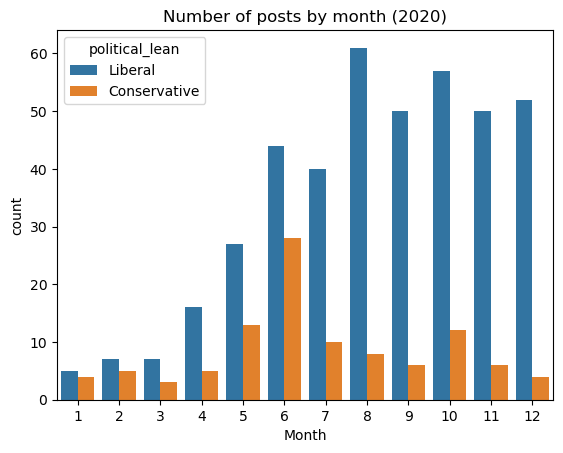

In [9]:
df.drop(columns=['subreddit'], inplace=True) 
# drop subreddit column since I've already got political_lean classification

# check distribution of these posts over the month in each year
sns.countplot(x='Month', data=df.loc[df['Year'] == 2020], hue='political_lean')
plt.title('Number of posts by month (2020)')
plt.show()

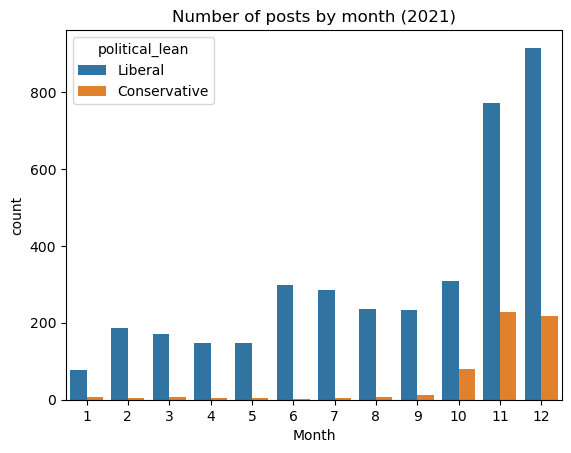

In [10]:
sns.countplot(x='Month', data=df.loc[df['Year'] == 2021], hue='political_lean')
plt.title('Number of posts by month (2021)')
plt.show()

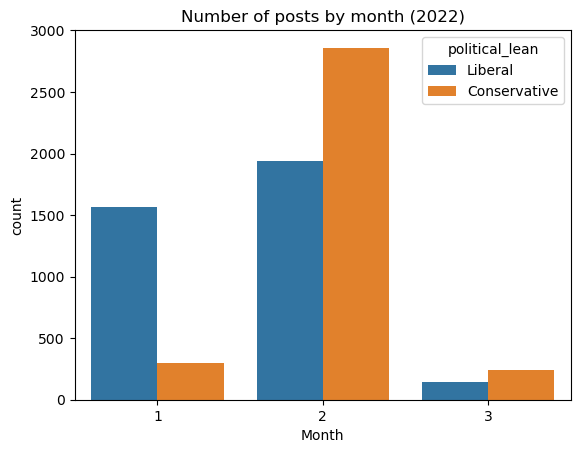

In [11]:
sns.countplot(x='Month', data=df.loc[df['Year'] == 2022], hue='political_lean')
plt.title('Number of posts by month (2022)')
plt.show()

Based on above three plots, we can tell that liberal leaning posts dominated those subreddits most of time, which is consistent with the claim that "Reddit is a liberal dominated platform."

However, from Feburary this year, conservative posts seem surged and outnumbered liberal posts (not sure if it is because of CPAC 2022).

In [12]:
# Anyway, based on all above discussions, and also because there were many big events happened in 2021, I decided to solely focus on 2021
df=df.loc[df['Year']==2021]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352 entries, 3650 to 12289
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           4352 non-null   object        
 1   political_lean  4352 non-null   object        
 2   score           4352 non-null   int64         
 3   comments_num    4352 non-null   int64         
 4   text            833 non-null    object        
 5   date            4352 non-null   datetime64[ns]
 6   Year            4352 non-null   int64         
 7   Month           4352 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 306.0+ KB


,title,political_lean,score,comments_num,text,date,Year,Month
3650,Lower taxes for the rich does not boost the ec...,Liberal,107,5,NaN,2021-12-31 23:48:46,2021,12
3651,How to convince my boomer parents of global co...,Liberal,4,3,"Hi, I am trying to be more open with my parent...",2021-12-31 23:36:48,2021,12
3652,Twitter,Liberal,2,1,Who do you follow? Who's interesting ?\n\nOn a...,2021-12-31 23:31:08,2021,12
3653,Florida Democrats blast 'MIA' Gov. Ron DeSanti...,Liberal,33,23,NaN,2021-12-31 23:25:28,2021,12
3654,Oh snap,Liberal,77,3,NaN,2021-12-31 22:05:23,2021,12


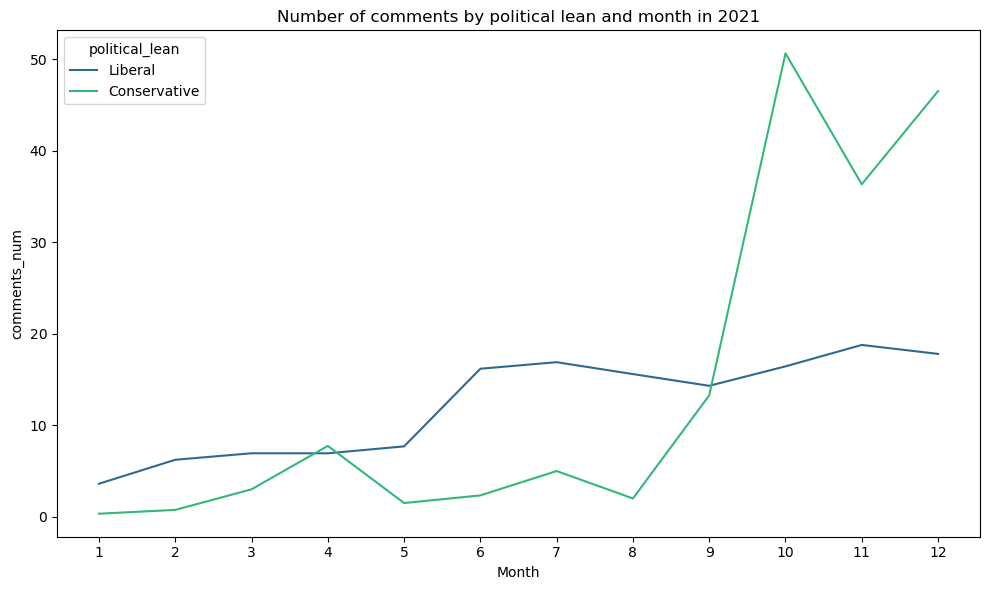

In [13]:
plt.figure(figsize = (10, 6))

months = df['Month'].unique()

sns.lineplot(x = 'Month', y = 'comments_num', hue = 'political_lean', ci = None, data=df, palette = 'viridis')
plt.title('Number of comments by political lean and month in 2021')
plt.xlabel('Month')
plt.xticks(ticks = [m for m in months])

plt.tight_layout()

It seems that from Sep, the comments that conservative posts got started to exceed liberal posts

# Data Preprocessing for Text Analysis

### Sample the dataset

In [14]:
df_sample = df.sample(frac =.15, random_state = 8)
  
# checking if sample is 0.15 times data or not
  
if (0.15*(len(df))== len(df_sample)):
    print( "Cool")
    print(len(df), len(df_sample))
  
# display
df_sample.drop(columns=['text', 'date', 'Year'], inplace=True) 
df_sample

,title,political_lean,score,comments_num,Month
5649,"YouTube cracks down on anti-vaccine videos, ba...",Liberal,147,8,9
5149,The Only Winning Climate Policy Is a Pro-Worke...,Liberal,30,25,11
5197,I think I'm a social Democrat but the middle c...,Liberal,15,12,11
3883,Harris charts her own course as vice-president...,Liberal,35,15,12
4745,One side protects the Status Quo and the other...,Liberal,986,12,11
...,...,...,...,...,...
7105,The Latest: Biden wants all adults vaccine-eli...,Liberal,27,0,3
5040,How the French ‘great replacement’ theory conq...,Liberal,14,0,11
6226,Matt Gaetz says Trump should become speaker of...,Liberal,24,29,7
5936,Pfizer's COVID Vaccine Gets Full Approval From...,Liberal,155,11,8


In [15]:
df_sample['title'].values[1]

'The Only Winning Climate Policy Is a Pro-Worker Climate Policy - we need material gains for the people rather than technocratic policies'

### Text normalization

I conduct preprocessing based on Kedia's book, with modifications on ways of dealing with shorhands, emojis and links since I'm dealing with social media posts.

Citation: Kedia, A., & Rasu, M. (2020). Hands-On Python Natural Language Processing: Explore Tools and Techniques to Analyze and Process Text with a View to Building Real-World NLP Applications, Packt Publishing, Limited, 2020. Chapter 3, p. 60-70.

In [16]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
#!pip install demoji
import demoji
from nltk.corpus import stopwords


stp_words=set(stopwords.words('english'))
stp_words.update(['mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 'amp', 'will', 'wa', 'like'])

CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "Don't": "Do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

stemmer=SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    #removing hastags and links
    pattern=re.compile(r"(#[a-zA-Z0-9]+|@[a-zA-Z0-9]+|http[s]?://\S+|www\.\S+|\S+\.[a-z]+[^A-Za-z0-9]+)")
    text=pattern.sub('',text)
    text=" ".join(text.split())
    
    # Any special character will be removed
    text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>+=-]", "", text)
    
    #make all lowercase
    text=text.lower()
    
    #stemming
    #text=" ".join([stemmer.stem(word) for word in text.split()])
    
    #lemmatizing
    text=" ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    #remove shortands
    s=''
    for word in text.split():
        if word in CONTRACTION_MAP.keys():
            s=s+' '+CONTRACTION_MAP[word];
        else:
            s=s+' '+word
    text=s
    
    #remove puncutations
    punc=re.compile(r"[^\w\s]")
    text=punc.sub('',text)
    
    #remove stop words
    text=" ".join(word for word in text.split() if word not in stp_words)
    
    #remove emojis
    emoji=demoji.findall(text)
    for emoj in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

    return text

In [17]:
line1=clean_text(df_sample['title'].values[1])
line1

'winning climate policy proworker climate policy need material gain people rather technocratic policy'

In [18]:
#adding a column for cleaned title
df_sample['clean_title_com']=df_sample['title'].apply(lambda x: clean_text(x))

# Drop rows with empty strings ('')
df_sample.drop(df_sample[df_sample['clean_title_com'] == ''].index, inplace = True)

# Counting duplicate data in dataframe
df_sample.duplicated().sum()

df_sample.info()
df_sample.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 5649 to 6833
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            652 non-null    object
 1   political_lean   652 non-null    object
 2   score            652 non-null    int64 
 3   comments_num     652 non-null    int64 
 4   Month            652 non-null    int64 
 5   clean_title_com  652 non-null    object
dtypes: int64(3), object(3)
memory usage: 35.7+ KB


,title,political_lean,score,comments_num,Month,clean_title_com
3982,21 Million+ Going Hungry in US as Manchin Tank...,Liberal,12,2,12,21 million going hungry manchin tank expanded ...
12071,A commercial for socialism that I made (that f...,Conservative,23,26,11,commercial socialism made reason rsocialism didnt
6508,Catholic leaders advance plan that could deny ...,Liberal,1,8,6,catholic leader advance plan could deny biden ...
4474,Stop voting for the Dems. Vote for Socialists....,Liberal,1811,200,12,stop voting dems vote socialist gallup sociali...
7269,California: State Bill Seeks To Make Californi...,Liberal,181,10,2,california state bill seek make california pay...
4750,What is a worrying issue that people don't tal...,Liberal,2,5,11,worrying issue people talk enough go first
11864,Is scalping goods a form of capitalism ?,Conservative,7,38,12,scalping good form capitalism
4517,The stakes in the debate over Bowman and Israel,Liberal,0,2,12,stake debate bowman israel
4186,"Democracy in America, Democracy in the World: ...",Liberal,8,3,12,democracy america democracy world reimagining ...
6401,A question for pro gun-control/ban Liberals.,Liberal,32,137,6,question pro guncontrolban liberal


### Text exploration

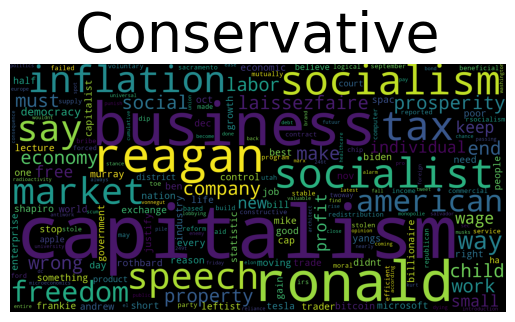

In [19]:
from wordcloud import WordCloud, STOPWORDS
def display_word_cloud(ideology_name, title):
    words = df_sample[df_sample['political_lean'] == ideology_name].clean_title_com
    cloud = WordCloud(background_color='black', width=2000, height=1000, colormap="viridis", collocations=False).generate(" ".join(words))
    plt.axis('off')
    plt.title(title,fontsize=40)
    plt.imshow(cloud)
    
display_word_cloud("Conservative", "Conservative")

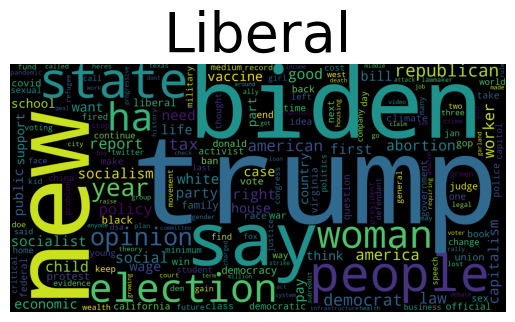

In [20]:
display_word_cloud("Liberal", "Liberal")

1
34
8.443251533742332


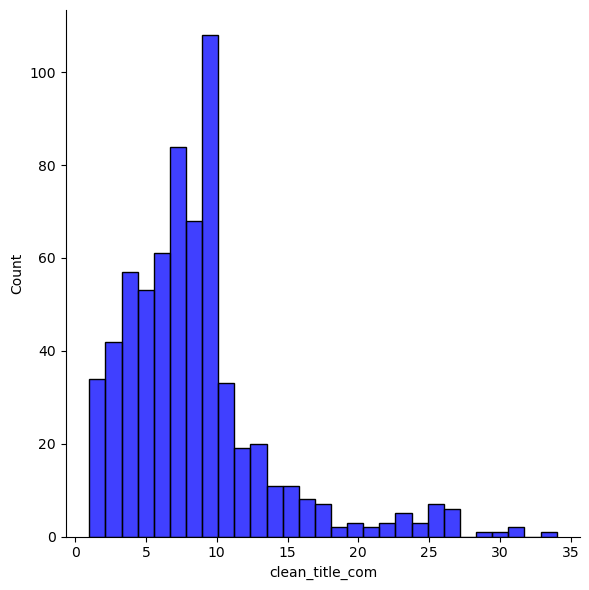

In [21]:
# The number of words in titles ranges from 1 to 34 words and is mostly 8 words.
temp = df_sample.clean_title_com.str.split().map(lambda x: len(x))

fig = sns.displot(x=temp, color='blue', kde=False, height=6, kind='hist')

print(temp.min())
print(temp.max())
print(temp.mean())

### N-gram exploration

The N-gram analysis mainly adopts BoW approach and CountVectorizer from Kedia's book.

Citation: Kedia, A., & Rasu, M. (2020). Hands-On Python Natural Language Processing: Explore Tools and Techniques to Analyze and Process Text with a View to Building Real-World NLP Applications, Packt Publishing, Limited, 2020. Chapter 4, p. 77-84.

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

corpus = []
text = df_sample.clean_title_com.str.split()
text = text.values.tolist()
corpus = [word for i in text for word in i]

from collections import defaultdict

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dinolu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    fwords_freq = []
    for i in words_freq:
        temp = 0
        for j in i[0].split():
            if j in stop:
                temp += 1
        if temp != len(i[0].split()):
            fwords_freq.append(i)
    words_freq = fwords_freq
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

In [24]:
# most mentioned bigrams are "ronald reagan", "donald trump", and "minimum wage"
top_n_bigrams = get_top_ngram(df_sample.clean_title_com, 2)[:10]
top_n_bigrams

[('ronald reagan', 8),
 ('donald trump', 7),
 ('minimum wage', 7),
 ('white house', 5),
 ('republican party', 5),
 ('fox news', 5),
 ('middle class', 4),
 ('small business', 4),
 ('reagan speech', 4),
 ('report say', 4)]

<AxesSubplot:>

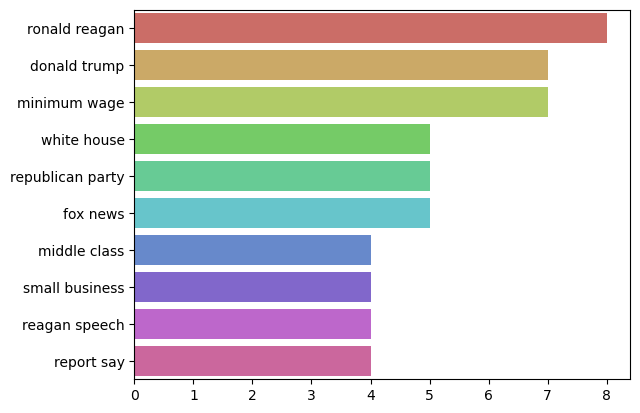

In [25]:
x, y = map(list, zip(*top_n_bigrams)) 

sns.barplot(x=y, y=x, palette='hls')

<AxesSubplot:>

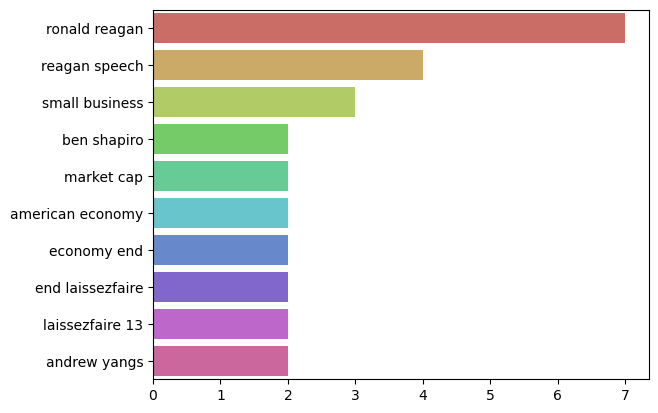

In [26]:
# most mentioned bigrams in conservative post titles
top_n_bigrams_C = get_top_ngram(df_sample.clean_title_com[df['political_lean']=='Conservative'], 2)[:10]

x, y = map(list, zip(*top_n_bigrams_C)) 

sns.barplot(x=y, y=x, palette='hls')

<AxesSubplot:>

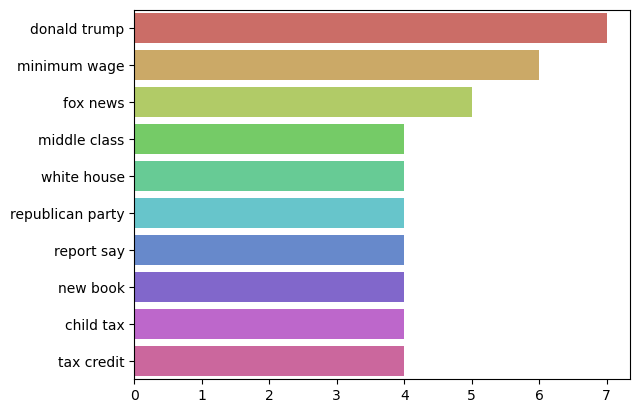

In [27]:
# most mentioned bigrams in liberal post titles
top_n_bigrams_L = get_top_ngram(df_sample.clean_title_com[df['political_lean']=='Liberal'], 2)[:10]

x, y = map(list, zip(*top_n_bigrams_L)) 

sns.barplot(x=y, y=x, palette='hls')

<AxesSubplot:>

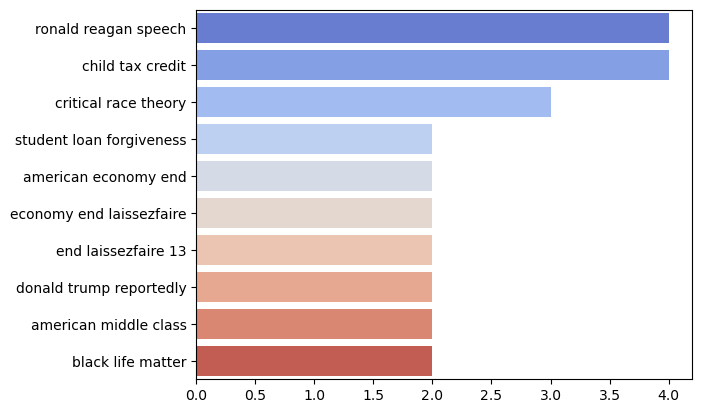

In [28]:
# most mentioned trigrams in all sample post titles
top_n_trigrams = get_top_ngram(df_sample.clean_title_com, 3)[:10]

x, y = map(list, zip(*top_n_trigrams)) 

sns.barplot(x=y, y=x, palette='coolwarm')

### I observe the following from above n-gram exploration of data (in 2021):
* People talked about Donald Trump and Ronald Reagan's speech a lot
* People concerned about economy market due to the bigrams "small business" "market cap" and "American economy"
* People also concerned about social well-being due to the bigram "minimum wage" and trigram "child tax credit"
* People were interested in the academic theory - "critical race theory"
* Surprisingly, people from both sides did not talk about COVID 19 and vaccines much during the time


# Sentiment Analysis


* Transformers is a library released by huggingface. This library downloads pretrained models for Natural Language Understanding (NLU) tasks, such as analyzing the sentiment of a text, or completing a prompt with new text or translating in another language. The TF tools source can be found here: https://huggingface.co/siebert/sentiment-roberta-large-english and here: https://github.com/facebookresearch/fairseq

This pretrained model usually has a good accuracy and based on whole sentence, but the downside is that it is significantly slower than others, and it only gives two classes: positive and negative (Liu et al.,2019).

Citation: Liu, Y. et al. (2019). ”RoBERTa: A robustly optimized BERT pretraining approach,” arXiv preprint arXiv:1907.11692, https://arxiv.org/abs/1907.11692
# 
* VADER(Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that works especially well with social media texts. VADER is unique because it uses the context of the surrounding words to understand the post titles' true sentiment. A person might said,"did not love", and VADER will classify it as negative, and not be confused by the positive word 'love'. This shows that VADER has been trained to better classify nuance in text. For this reason it works better for social media commments than a traditional Lexicon Word Counter (Hutto & Gilbert, 2014). The VADER tools source can be found here: https://github.com/cjhutto/vaderSentiment

Citation: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

The article includes comparisons between several mainstream sentiment analysis approaches, and it seems that VADER performs at least better than TextBlob. https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4
## 
Both Transformers and VADER can use punctuation and other features to gather polarity scores, the data does not need too much preprocessing, so I'll do slight preprocessing and create a new column with these slightly cleaned titles called "clean_title" to differentiate from previous "clean_title_com(plete)"

In [29]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "Don't": "Do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

def clean_text_slightly(text):
    #removing hastags and links
    pattern=re.compile(r"(#[a-zA-Z0-9]+|@[a-zA-Z0-9]+|http[s]?://\S+|www\.\S+|\S+\.[a-z]+[^A-Za-z0-9]+)")
    text=pattern.sub('',text)
    text=" ".join(text.split())
    
    #remove shortands
    s=''
    for word in text.split():
        if word in CONTRACTION_MAP.keys():
            s=s+' '+CONTRACTION_MAP[word];
        else:
            s=s+' '+word
    text=s

    return text

#adding a column for cleaned title
df_sample['clean_title']=df_sample['title'].apply(lambda x: clean_text_slightly(x))
df_sample.sample(10)

,title,political_lean,score,comments_num,Month,clean_title_com,clean_title
3875,This triggered people on other subreddits.,Liberal,362,3,12,triggered people subreddits,This triggered people on other subreddits.
6341,"Opinion | Drive the all-new Toyota Paranoia, O...",Liberal,33,1,7,opinion drive allnew toyota paranoia official ...,"Opinion | Drive the all-new Toyota Paranoia, ..."
6599,The Double Exploitation of Deepfake Porn,Liberal,2,0,6,double exploitation deepfake porn,The Double Exploitation of Deepfake Porn
3969,Dear Comrade Ronald Reagan unironically praisi...,Liberal,67,18,12,dear comrade ronald reagan unironically praisi...,Dear Comrade Ronald Reagan unironically prais...
6428,Hot take for a liberal,Liberal,11,36,6,hot take liberal,Hot take for a liberal
6694,Cheney fires back at Flynn over coup remark,Liberal,17,14,6,cheney fire back flynn coup remark,Cheney fires back at Flynn over coup remark
4190,Towards Shareholder Socialism? An interview wi...,Liberal,9,0,12,towards shareholder socialism interview giacom...,Towards Shareholder Socialism? An interview w...
4332,"Fuck it, Happy Scholz",Liberal,74,3,12,fuck happy scholz,"Fuck it, Happy Scholz"
6730,Question about Critical Race Theory (CRT),Liberal,1,3,5,question critical race theory crt,Question about Critical Race Theory (CRT)
7218,"Many Americans, especially families, can’t liv...",Liberal,193,21,2,many american especially family cant live 15 m...,"Many Americans, especially families, can’t li..."


### [HuggingFace Transformers]

In [30]:
from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [31]:
transformer_sentiments = df_sample.clean_title.apply(sentiment_analysis)

labels = []
scores = []
for sentiment in transformer_sentiments:
    #print(f"label: {sentiment[0]['label']}, with score: {round(sentiment[0]['score'], 4)}")
    labels.append(sentiment[0]['label'])
    scores.append(round(sentiment[0]['score'], 4))
    
df_sample['tf_sentiment'] = labels
df_sample['tf_score'] = scores

df_sample[['clean_title', 'tf_score', 'tf_sentiment']].head(3)

,clean_title,tf_score,tf_sentiment
5649,"YouTube cracks down on anti-vaccine videos, b...",0.9996,NEGATIVE
5149,The Only Winning Climate Policy Is a Pro-Work...,0.9063,NEGATIVE
5197,I think I'm a social Democrat but the middle ...,0.7726,NEGATIVE


In [32]:
# take a look at some of the positive and negative texts.
for i in df_sample[df_sample.tf_sentiment == 'POSITIVE'].clean_title.sample(5):
    print(i)
    print()

 Noticed something interesting about the Maricopa audit presentation

 The Other Love Story | WLW | Bollywood | Series

 Politician and CEO pay

 Miss Nevada trailblazes her way into Miss USA pageant as its 1st transgender contestant

 Biden has convinced allies 'America is back,' says France's Macron



In [33]:
for i in df_sample[df_sample.tf_sentiment == 'NEGATIVE'].clean_title.sample(5):
    print(i)
    print()

 UK: Tampon tax abolished from today (January 1, 2021)

 Greek Socialist leader Gennimata dies after long illness

 How do you quickly recover from masogyn-isms(?) instead of getting derailed?

 Anger, condemnation after Turkey exits treaty to protect women

 'They're not going to f**king succeed': Top generals feared Trump would attempt a coup after election, according to new book



### [NLTK VADER]

In [34]:
# conda install -c anaconda nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dinolu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
def find_sentiment(text):
    if sia.polarity_scores(text)["compound"] >= 0.05:
        return "POSITIVE"
    elif sia.polarity_scores(text)["compound"] <= (-0.05):
        return "NEGATIVE"
    else:
        return "NEUTRAL" 

    
vader_sentiments = df_sample.clean_title.apply(find_sentiment)
df_sample['vader_sentiment'] = vader_sentiments

df_sample[['clean_title', 'vader_sentiment']].head(3)

,clean_title,vader_sentiment
5649,"YouTube cracks down on anti-vaccine videos, b...",NEUTRAL
5149,The Only Winning Climate Policy Is a Pro-Work...,POSITIVE
5197,I think I'm a social Democrat but the middle ...,POSITIVE


### Comparison!

Distribution of classes : Transformers


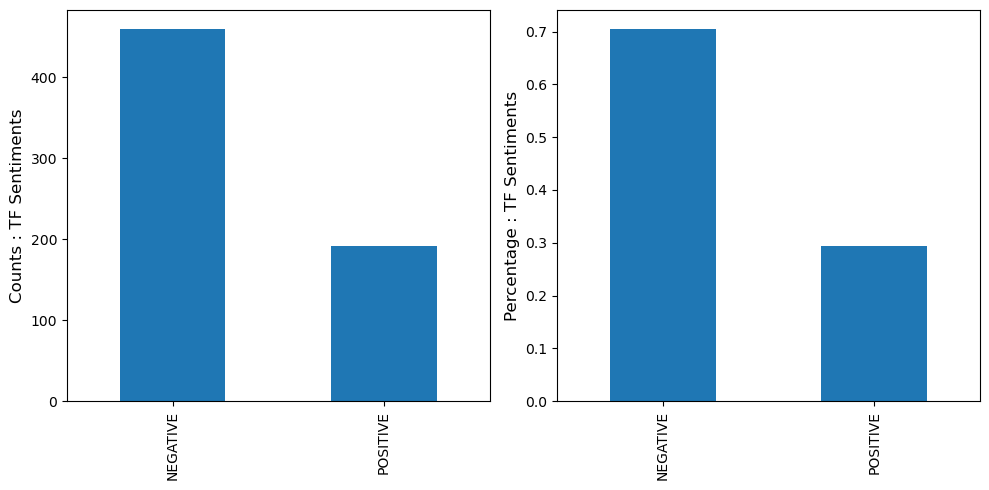

In [36]:
## Make a df just for comparision
df_comparison = df_sample[['clean_title', 'tf_sentiment', 'vader_sentiment']]


# plot distribution of sentiment classes of Transformers results
print("Distribution of classes : Transformers")
counts = df_comparison['tf_sentiment'].value_counts()
percent = counts/sum(counts)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

counts.plot(kind='bar', ax=ax1)
percent.plot(kind='bar', ax=ax2)
ax1.set_ylabel('Counts : TF Sentiments', size=12)
ax2.set_ylabel('Percentage : TF Sentiments', size=12)
plt.tight_layout()
plt.show()

More negative titles than positive ones based on Transformers sentiment analysis results

Distribution of classes : Vader


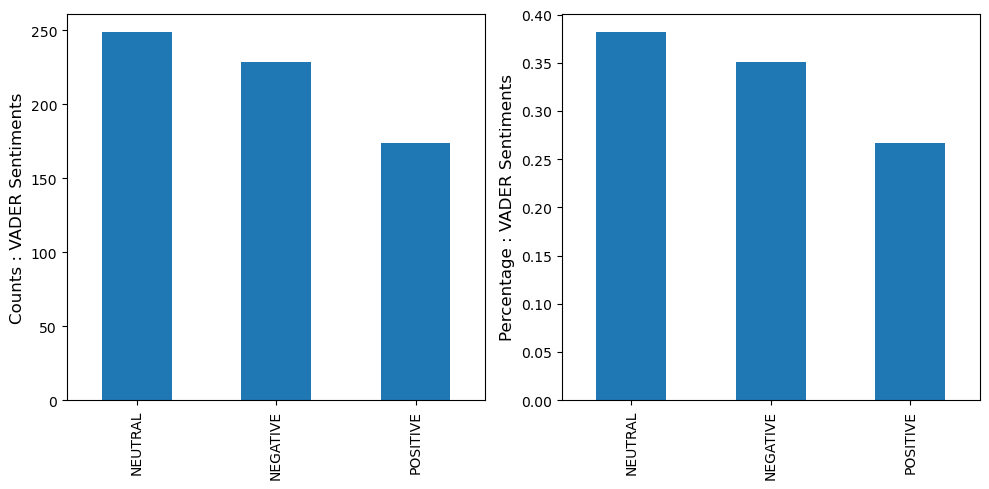

In [37]:
# plot distribution of sentiment classes of VADER results
print("Distribution of classes : Vader")
counts = df_comparison['vader_sentiment'].value_counts()
percent = counts/sum(counts)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

counts.plot(kind='bar', ax=ax1)
percent.plot(kind='bar', ax=ax2)
ax1.set_ylabel('Counts : VADER Sentiments', size=12)
ax2.set_ylabel('Percentage : VADER Sentiments', size=12)
plt.tight_layout()
plt.show()

Neutral titles are the most proportion among all three classes, and positive ones still the least, based on VADER sentiment results

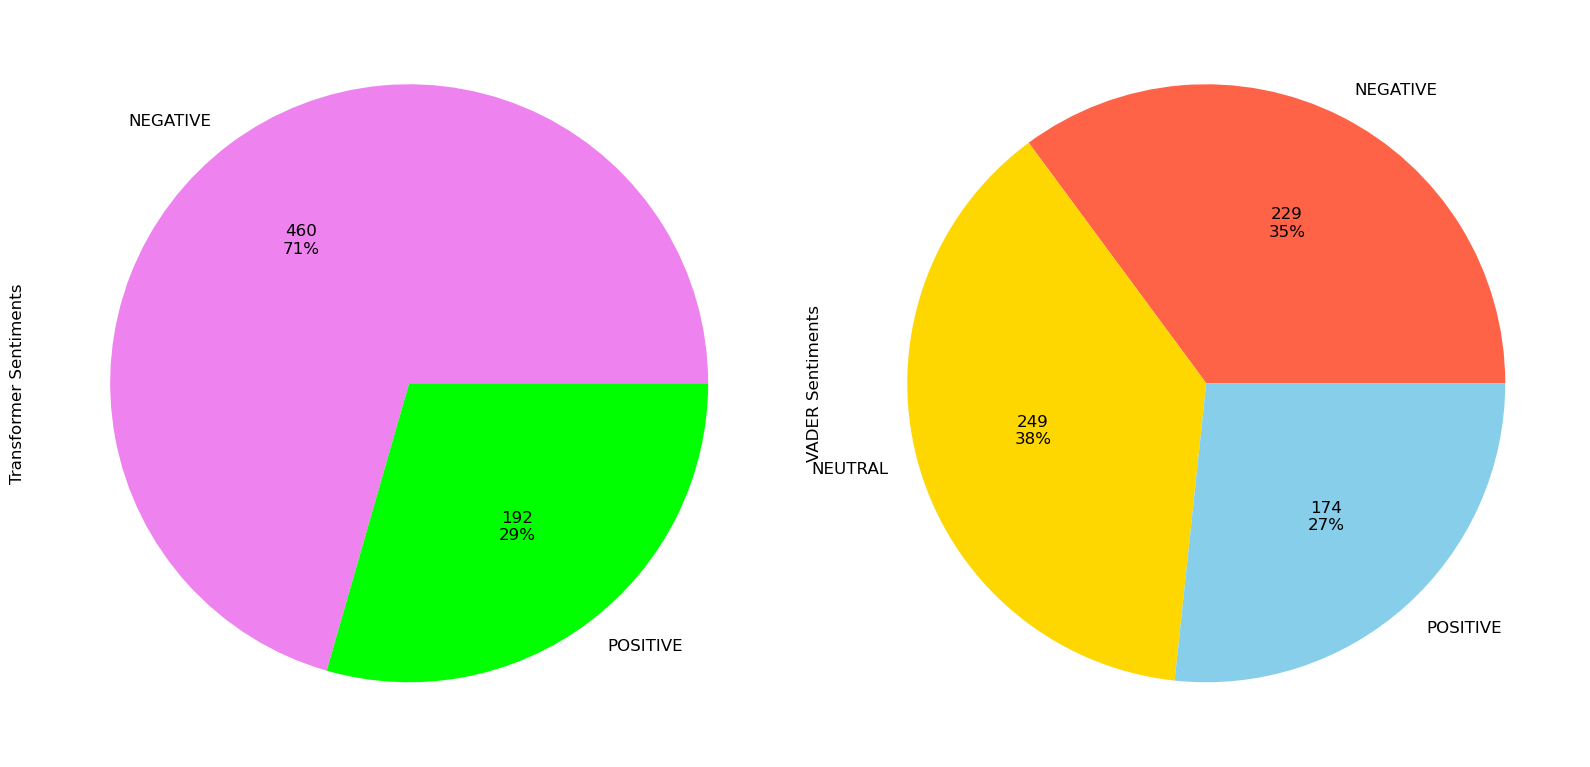

In [38]:
# a more direct way to look at the different proportions of class distributions
def label_function(val):
    return f'{val / 100 * len(df_comparison):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))


df_comparison.groupby('tf_sentiment').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 12},
                                 colors=['violet', 'lime'], ax=ax1)
df_comparison.groupby('vader_sentiment').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'], ax=ax2)


ax1.set_ylabel('Transformer Sentiments', size=12)
ax2.set_ylabel('VADER Sentiments', size=12)
plt.tight_layout()
plt.show()

The comparison pie charts clearly show that the proportion and number of positive sentiment titles are quite similar between the two methods. The difference is mainly on Negative and Neutral, and half of negative titles in TF results are coded as neutral in Vader results, probably because VADER provides 3-polarity sentiment whereas TF only has two.

* Anyway, I decide to explore more on TF results and do some visualization on it

# Visualization of TF_sentiment

In [39]:
# create a cross tabulation that shows the proportion of the sentiment class for each political lean
cross_tab = pd.crosstab(index=df_sample['political_lean'],
                             columns=df_sample['tf_sentiment'])     
cross_tab

cross_tab_prop = pd.crosstab(index=df_sample['political_lean'],
                             columns=df_sample['tf_sentiment'],
                             normalize="index")
cross_tab_prop

tf_sentiment,NEGATIVE,POSITIVE
political_lean,,
Conservative,0.645570,0.354430
Liberal,0.713787,0.286213


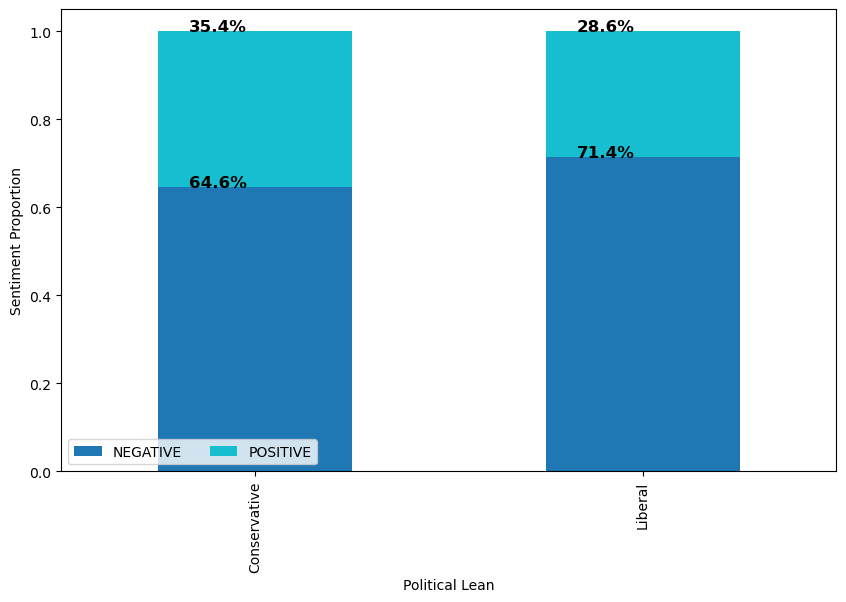

In [40]:
# plot a stacked column chart
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Political Lean")
plt.ylabel("Sentiment Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")


plt.show()

After corss comparing the two attributes: political lean and sentiment, the above stacked bar chart clearly shows that both left and right wings post more negative posts (at least for titles), and the distribution proportions are also quite similar.

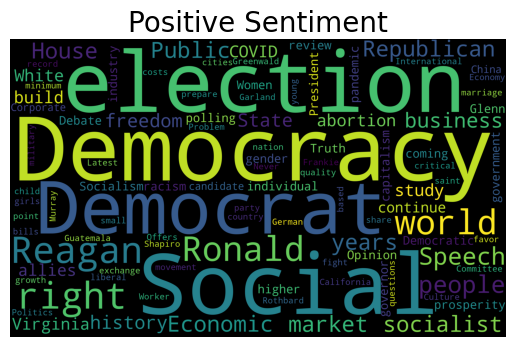

In [41]:
# generate word clouds for both positive and negative sentiment
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Get stopwords from wordcloud library
stopwords = set(STOPWORDS)
 
# Add some extra words ad hoc for our purpose
add_words = ['trump', 'biden', 'donald','first','American','America']
stopwords.update(add_words)

def display_word_cloud(sentiment, name):
    words = df_sample[df_sample['tf_sentiment'] == sentiment].clean_title
    cloud = WordCloud(stopwords=stopwords, background_color='black', max_words=100, min_word_length=5, width=2500, height=1500, colormap="viridis", collocations=False).generate(" ".join(words))
    plt.axis('off')
    plt.title(name,fontsize=20)
    plt.imshow(cloud)
    
display_word_cloud("POSITIVE", "Positive Sentiment")
plt.savefig('positive sentiment.png', dpi=120, bbox_inches='tight')

After excluding "trump" and "biden", which are the most mentioned words in both sides, the highly mentioned words in positive sentiment titles are "social" "democracy" and "election" and so on, which means that people might had positive attitudes toward elections and democracy at the time considering that Reddit is more liberal dominated.

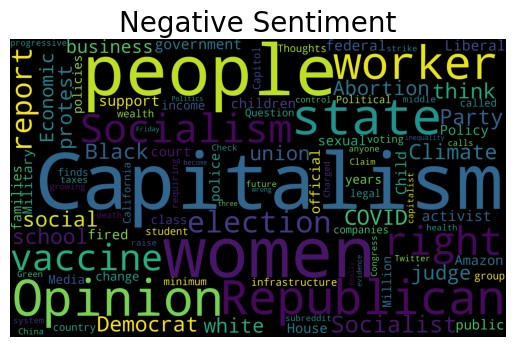

In [42]:
display_word_cloud("NEGATIVE", "Negative Sentiment")
plt.savefig('negative sentiment.png', dpi=120, bbox_inches='tight')

Most mentioned words in negative sentiment titles are "capitalism", "opinion", "women", "climateparty" and "vaccine" and so on. Still considering the liberal oriented feature, it probably means that people have concern about capitalism and be disatisfied with women's situation in society (gender equality).

# Conclusion

From text exploration and sentiment analysis, I observed the following:

Around 70% of the sentiments were negative based on Transformers, and both left and right wings post in a more negative way than positive. This could be because: 1. social media amplified offline attitudes and emotions, especially "rage"; 2. people are aware of the engagement-based ranking algorithms of social media platforms, which anger or disputed posts can improve visibility and draw more viewers and comments. In other words, social media affordances can influence the way people behave online and encourage people to post in a more negative way (Wollebæk, et al., 2019; SUN & Suthers, 2021).

Citations:

Wollebæk, D., Karlsen, R., Steen-Johnsen, K., & Enjolras, B. (2019). Anger, Fear, and Echo Chambers: The Emotional Basis for Online Behavior. Social Media + Society, 5(2). https://doi.org/10.1177/2056305119829859

SUN, Y., & Suthers, D.D. (2021). Cultural Affordances and Social Media. Proceedings of the 54th Hawaii International Conference on System Sciences. https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/277510cd-cc0b-40e0-a4ce-b19358e89c69/content

Another discovery was based on the frequently mentioned words of each class. It seems that the positive sentiment discussions on Reddit were centered more on national- or governmental-level (macro-) topics, such as election and democracy, whereas the negative sentiment disccusions focused more on social and individual-level topics (micro-), such as "women", "worker", "opinion", "people" and so on. But of course, more work needs to be done in future research to explore more.

However, it is important not to forget the limitations of data, methodology and findings:
1. Social media users are not representative of the underlying population offline, especially Reddit is more biased and oriented by one politicla lean.
2. Results from Reddit data are not generalizable to all countries and all time, considering that a large proportion of Reddit users are located in the U.S. and the data of this project is only a sample in 2021.
3. I do not have pre-labeled historical dataset to train machine learning model for sentiment prediction, so that I can only use rule-based approach.
4. This dataset is probably more suitable for approaches like topic modeling and text classfication (predicting political lean), but since other people have already done those types of work, I think I might practice those approaches in the future on other datasets.


### References

Chipidza, W., Krewson, C., Gatto, N., Akbaripourdibazar, E., & Gwanzura, T. (2022). Ideological variation in preferred content and source credibility on Reddit during  the COVID-19 pandemic. Big Data & Society, 9(1). https://doi.org/10.1177/20539517221076486

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

Kedia, A., & Rasu, M. (2020). Hands-On Python Natural Language Processing: Explore Tools and Techniques to Analyze and Process Text with a View to Building Real-World NLP Applications, Packt Publishing, Limited, 2020.

Liu, Y. et al. (2019). ”RoBERTa: A robustly optimized BERT pretraining approach,” arXiv preprint arXiv:1907.11692, https://arxiv.org/abs/1907.11692

SUN, Y., & Suthers, D.D. (2021). Cultural Affordances and Social Media. Proceedings of the 54th Hawaii International Conference on System Sciences. https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/277510cd-cc0b-40e0-a4ce-b19358e89c69/content

Wollebæk, D., Karlsen, R., Steen-Johnsen, K., & Enjolras, B. (2019). Anger, Fear, and Echo Chambers: The Emotional Basis for Online Behavior. Social Media + Society, 5(2). https://doi.org/10.1177/2056305119829859